In [1]:
%%capture
%run ./Config.ipynb # run this cell only once
%run ./Clean.ipynb # run this cell only once

### Read Data File

In [2]:
path_price = os.path.dirname(os.getcwd())
raw_prices = pd.read_excel(os.path.join(path_price, "data/prices.xlsx")) # read raw dataset

## Using Euclidean Distance, Cosine Similarity and correlation to determine companies that behave similarly

### Euclidean Distance

In [3]:
def calc_euclidean_dist(df):
    
    # first transform the dataframe to wide format and convert prices to % change from previous day
    
    df = clean_price(raw_prices)
    df = df[df['Feature'] == 'Adj Close']
    df = df.drop('Feature', axis = 1).dropna()
    df = df.pivot(index = "Date", columns="ticker", values="price").pct_change()*100
    df = df.dropna()
    
    # Takes in a DataFrame and computes all pairwise Euclidean Distance
    
    n = df.shape[1] 
    dm = np.zeros((n,n)) # initialize the distance matrix to zero

    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            dm[i,j] = np.sqrt(np.sum((df.iloc[:,i] - df.iloc[:,j])**2))

    euclidean_dist_df = pd.DataFrame(dm)
    euclidean_dist_df.columns = df.columns # adding col names
    euclidean_dist_df['Ticker'] = df.columns.values # adding row
    euclidean_dist_df.set_index('Ticker', inplace = True) # setting index for stocks
    
    # From pairwise Euclidean Distance, output df with each value pair in a col
    
    lst = [] #initialise list
    
    for i in range(len(euclidean_dist_df.columns)):
        for j in range(len(euclidean_dist_df.columns)):
            lst.append([euclidean_dist_df.columns[i], 
                        euclidean_dist_df.columns[j], euclidean_dist_df.iat[i,j]])

    df = round(pd.DataFrame.from_records(lst),0)
    df.columns = ['Ticker_1','Ticker_2','Euclidean Distance']
    
    df = df[df['Euclidean Distance'] > 0].sort_values(['Euclidean Distance'], ascending = True)
    df = df.loc[pd.DataFrame(np.sort(df[['Ticker_1','Ticker_2']],1), 
                             index = df.index).drop_duplicates(keep='first').index] # removing pairwise duplication of pairs

    return df

In [4]:
#calc_euclidean_dist(raw_prices) #uncomment to view df

### Cosine Similarity

In [5]:
def cosine_similarity(df):
    from numpy import dot # import here as import from config gets error
    from numpy.linalg import norm # import here as import from config gets error
    
    # first transform the dataframe to wide format and convert prices to % change from previous day
    df = clean_price(raw_prices)
    df = df[df['Feature'] == 'Adj Close']
    df = df.drop('Feature', axis = 1).dropna()
    df = df.pivot(index = "Date", columns="ticker", values="price").pct_change()*100
    df = df.dropna()
    
    # Takes in a DataFrame and computes all pairwise Cosine similarity
    
    n = df.shape[1]
    dm = np.zeros((n,n)) # initialize the distance matrix to zero

    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            x = df.iloc[:,i].values
            y = df.iloc[:,j].values
            dm[i,j] = dot(x, y)/(norm(x)*norm(y))

    cosine = pd.DataFrame(dm)
    cosine.columns = df.columns # adding col names
    cosine['Ticker'] = df.columns.values # adding row
    cosine.set_index('Ticker', inplace = True) # setting index for stocks
    
    # From pairwise Euclidean Distance, output df with each value pair in a col
    
    lst = [] #initialise list
    
    for i in range(len(cosine.columns)):
        for j in range(len(cosine.columns)):
            lst.append([cosine.columns[i], 
                        cosine.columns[j], cosine.iat[i,j]])

    df = round(pd.DataFrame.from_records(lst),0)
    df.columns = ['Ticker_1','Ticker_2','Cosine Similarity']
    df = df.sort_values(['Cosine Similarity'], ascending = False)

    return df

In [6]:
#cosine_similarity(raw_prices)

### Correlation Calculation

In [7]:
def correlation_df_chart(df):
    
    df = clean_price(df)
    df = df[df['Feature'] == 'Adj Close']
    df = df.drop('Feature', axis = 1).dropna()
    df = df.pivot(index = "Date", columns="ticker", values="price").pct_change()*100
    df = df.dropna()
    df = round(df.corr()*100,0)


    lst = [] #initialise list

    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            lst.append([df.columns[i], 
                        df.columns[j], df.iat[i,j]])

    df = pd.DataFrame.from_records(lst)
    df.columns = ['Ticker_1','Ticker_2','Correlation']
    df = df.sort_values(['Correlation'], ascending = False)

    # create heatmap visualisation
    #++++++++++++++++++++++++++++++++++++++++++++++++++++

    # base chart
    base = alt.Chart(df).encode(x='Ticker_1:O',y='Ticker_2:O')
    # text and colours 
    text = base.mark_text().encode(text='Correlation:Q',color= alt.condition(
        alt.datum.Correlation > 80.0, 
        alt.value('white'),
        alt.value('black')))

    # correlation heatmap 
    cor_plot = base.mark_rect().encode(color='Correlation:Q')

    chart = (cor_plot + text).properties(height = 500, width = 500)

    # removing pairwise duplication of pairs
    #+++++++++++++++++++++++++++++++++++++++++++++++++++++
    
    return df, chart

In [8]:
#correlation_df_chart(raw_prices)[0] #uncomment to see correlation df
#correlation_df_chart(raw_prices)[1] #uncomment to see correlation heatmap

### Merge both similarity measures + correlation

In [9]:
merge_similarities = calc_euclidean_dist(raw_prices).merge(cosine_similarity(raw_prices), 
                                                           left_on = ['Ticker_1','Ticker_2'], 
                                                           right_on = ['Ticker_1','Ticker_2'], how = 'left')
merge_similarities = merge_similarities.merge(correlation_df_chart(raw_prices)[0], 
                                              left_on = ['Ticker_1','Ticker_2'], 
                                              right_on = ['Ticker_1','Ticker_2'], 
                                              how = 'left').sort_values(['Correlation'], ascending = False)

In [10]:
merge_similarities #uncomment to see merged euc, cosine, correlation

,Ticker_1,Ticker_2,Euclidean Distance,Cosine Similarity,Correlation
0,SPY,^GSPC,3.0,1.0,100.0
2,^RUA,SPY,8.0,1.0,99.0
1,^RUA,^GSPC,8.0,1.0,99.0
8,QQQ,SPY,23.0,1.0,92.0
7,QQQ,^GSPC,23.0,1.0,92.0
...,...,...,...,...,...
67,GOVT,QQQ,63.0,-0.0,-29.0
52,GOVT,EFA,53.0,-0.0,-33.0
58,GOVT,^RUA,55.0,-0.0,-36.0
59,GOVT,^GSPC,55.0,-0.0,-37.0


## Single Time Series Forecasting  

### Stationarity test - Augmented Dickey-Fuller unit root test on log-difference time series

In [11]:
def adf(df):
    
    # taking the log difference
    df = clean_price(df) 
    df = df[df['Feature'] == 'Adj Close']
    df = df.set_index(pd.DatetimeIndex(df['Date'])) # setting index
    df = df.drop(['Feature','Date'], axis = 1).dropna()

    lst = [] # initialise list
    for var in df.ticker.unique():
        data = df[df['ticker'] == var]
        data = data.drop(['ticker'], axis = 1).dropna()
        log_ret = np.log(data['price']/data['price'].shift(1)).dropna()
        _, pval, *_ = adfuller(log_ret)
        lst.append([var, pval])
        
    df = pd.DataFrame.from_records(lst)
    df.columns = ['ticker','p-value']
    df['Is time series stationary?'] = np.where(df['p-value'] < LOS, 'Yes', 'No')
    
    return df

In [12]:
#adf(raw_prices)

,ticker,p-value,Is time series stationary?
0,AAPL,2.112799e-29,Yes
1,AGG,1.146133e-22,Yes
2,AMD,0.000000e+00,Yes
3,AMZN,1.342359e-23,Yes
4,BABA,4.266745e-14,Yes
5,EFA,8.603000e-29,Yes
6,EMB,1.152891e-18,Yes
7,FB,1.328303e-29,Yes
8,GLD,0.000000e+00,Yes
9,GOOG,0.000000e+00,Yes


##  Autocorrelation Function (ACF) & Partial Autocorrelation Function (PACF)

In [13]:
def acf_pacf_plots(df):
    df = clean_price(df) 
    df = df[df['Feature'] == 'Adj Close']
    df = df.set_index(pd.DatetimeIndex(df['Date'])) # setting index
    df = df.drop(['Feature','Date'], axis = 1).dropna()

    lst = [] # initialise list
    for var in df.ticker.unique():
        data = df[df['ticker'] == var]
        data = data.drop(['ticker'], axis = 1).dropna()

        fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(15, 5))

        plot_acf(data, axes[0], lags = max_lag, title = "Daily stock price movements of" + ' '+ var)
        axes[0].set_xlabel(r"Lag")
        axes[0].set_ylabel(r"Correlation")

        plot_pacf(data, axes[1], lags = max_lag, title = "Daily stock price movements of" + ' '+ var)
        axes[1].set_xlabel(r"Lag")
        axes[1].set_ylabel(r"Partial Correlation")


In [14]:
# acf_pacf_plots(raw_prices) #uncomment to see correlation plots for each stock

## ARMA based on Log-price movements - Forecasting

In [38]:
def draw_ARMA_plot(df, stock = ''):
    
    # some cleaning
    df = clean_price(df) 
    df = df[df['Feature'] == 'Adj Close']
    df = df.drop(['Feature'], axis = 1).dropna()
    
    # selecting the stock
    data = df[df['ticker'] == stock]
    data = data.drop(['ticker'], axis = 1).dropna()
    data = data[(data['Date'] > "2017-01-01")].set_index('Date') # only taking in data from 2017 onwards
    
    #split data into train and training set
    train_data, test_data = data[0:int(len(data)*0.8)], data[int(len(data)*0.8):] #80% training, 20% test
    model = ARIMA(np.log(train_data), order = (max_lag, 1 ,max_lag)) # we will use 16 lags for forecasting
    model_fit = model.fit()

    # forecasting 
    delta = (test_data.index.max() - train_data.index.max())
    num_forecasts = delta.days
    forecasts = np.exp(model_fit.forecast(num_forecasts)).reset_index()
    date_max = train_data.index.max() + datetime.timedelta(days = 1) # Find max date of train_data
    forecasts['index'] = pd.date_range(date_max, periods = num_forecasts) # replace index values
    forecasts.rename(columns = {'index':'Date'}, inplace = True) # Rename index 
    forecasts = forecasts.set_index('Date') # set df index to date

    # get confidence interval bands
    objs = model_fit.get_forecast(num_forecasts)
    conf_int = np.exp(objs.conf_int(alpha=0.5)) # using 50% confidence interval
    conf_int['Date'] = pd.date_range(date_max, periods = num_forecasts)
    conf_int = conf_int.set_index('Date')


    # plotting 1
    plt.figure(figsize=(10,6))
    plt.xlabel('Period')
    plt.ylabel('Adj Closing Prices')
    plt.title("Stock price movements for " + stock + ' since 2017')
    plt.plot(data, 'darkblue', label = 'Train data')
    plt.plot(test_data, 'darkred', label = 'Test data')
    plt.legend()

    # plotting 3
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.plot(train_data, label = "Original")
    train_data.rename(columns = {'price':'predicted_mean'}, inplace = True) # so that appending forecast occurs
    ax.plot(train_data[-1:].append(forecasts), label = "Predicted MA with 50% confidence")
    train_data.rename(columns = {'predicted_mean':'price'}, inplace = True) # so that appending test_data occurs
    ax.plot(train_data[-1:].append(test_data), label = "Actual")
    plt.fill_between(conf_int.index, 
             conf_int['lower price'], 
             conf_int['upper price'], 
             color='k', alpha = 0.1)

    ax.set_xlabel("Period")
    plt.ylabel('Adj Closing Prices')
    ax.set_title("Stock price for " + stock + ' for ' + str(num_forecasts) + "-day forecast with 7 lags")
    ax.legend()

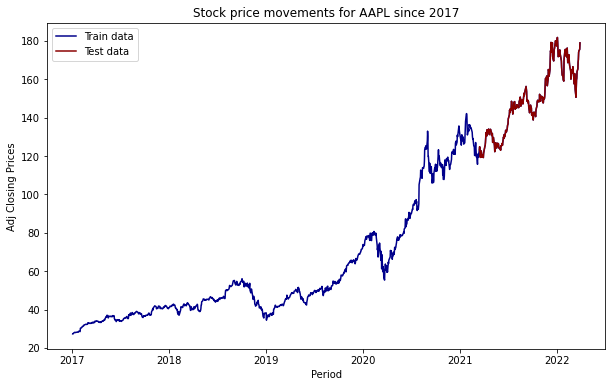

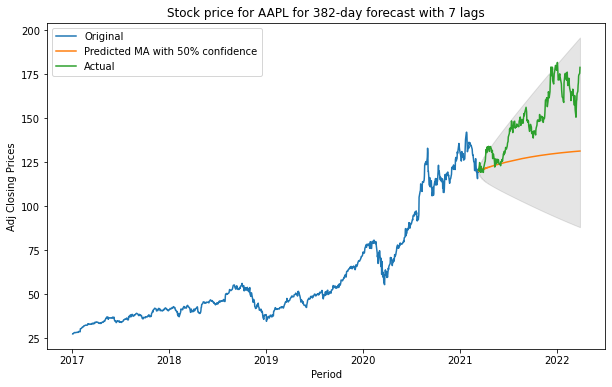

In [39]:
#draw_ARMA_plot(raw_prices, 'AAPL')

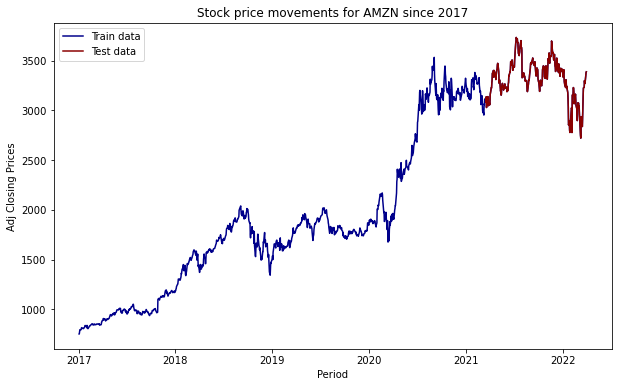

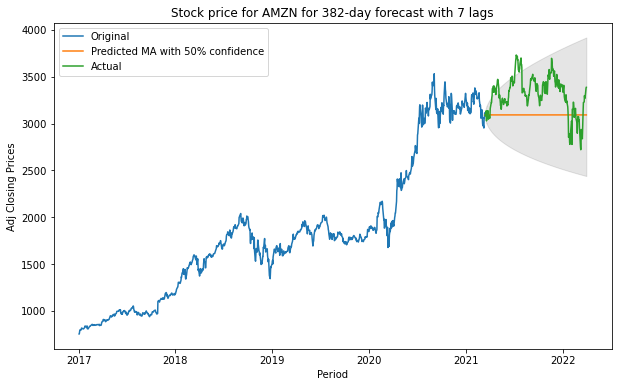

In [40]:
#draw_ARMA_plot(raw_prices, 'AMZN')